In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/My Drive/Plant_Diseases.zip'

# Extract the zip file
unzip_path = '/content/dataset'
os.makedirs(unzip_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

print("Dataset extracted to:", unzip_path)

Dataset extracted to: /content/dataset


Importing Required Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Loading data

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_dir = 'dataset/dataset/New Plant Diseases Dataset(Augmented)/train'
val_dir = 'dataset/dataset/New Plant Diseases Dataset(Augmented)/valid'

# Initialize ImageDataGenerators with rescaling
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Use flow_from_directory to load data in batches
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print class indices to understand label encoding
print("Class indices (label mapping):", train_generator.class_indices)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Class indices (label mapping): {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Str

Class Distribution Analysis

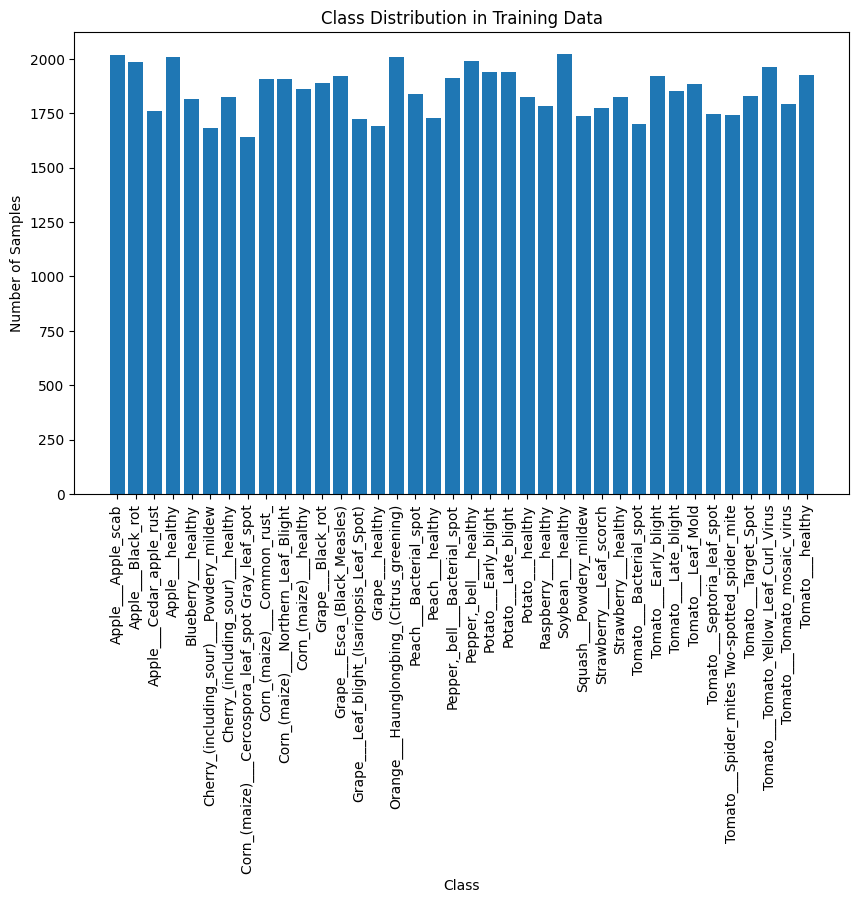

In [ ]:
# Get the class distribution (number of samples per class)
class_counts = {k: 0 for k in train_generator.class_indices.keys()}

# Count the number of samples in each class
for i in range(len(train_generator.filenames)):
    class_name = train_generator.filenames[i].split('/')[0]
    class_counts[class_name] += 1

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=90)
plt.show()

Sample images

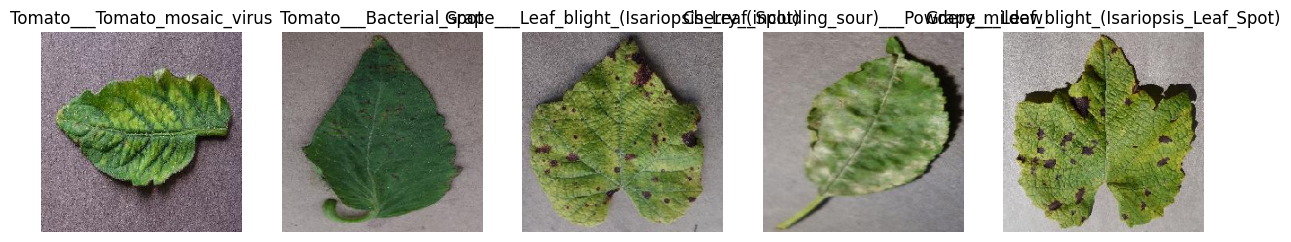

In [ ]:
# Get a batch of images from the generator
images, labels = next(train_generator)

# Display the first 5 images in the batch
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    axes[i].imshow(images[i])  # Show image
    axes[i].axis('off')  # Hide axes
    label = train_generator.class_indices.keys()
    label_index = np.argmax(labels[i])
    axes[i].set_title(list(label)[label_index])  # Show the corresponding class label
plt.show()

Shape and Dimensions of Data

In [ ]:
batch_images, batch_labels = next(train_generator)

print(f"Batch of images shape: {batch_images.shape}")
print(f"Batch of labels shape: {batch_labels.shape}")

Batch of images shape: (32, 224, 224, 3)
Batch of labels shape: (32, 38)


Sample Labels

In [ ]:
for i in range(5):
    label_index = np.argmax(batch_labels[i])
    print(f"Image {i}: {list(train_generator.class_indices.keys())[label_index]}")

Image 0: Potato___healthy
Image 1: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Image 2: Tomato___Early_blight
Image 3: Raspberry___healthy
Image 4: Peach___Bacterial_spot


In [ ]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

# Model Creation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

Loading Pretrained ResNet50 model

In [ ]:
input_shape = (224, 224, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
print("Base model output shape:", base_model.output_shape)
# Freeze the base model
base_model.trainable = False

# Create a new model
model = Sequential([
    base_model,  # Add ResNet50 as the base model
    GlobalAveragePooling2D(),  # Pool the output of the convolution layers
    Dropout(0.5),  # Add Dropout for regularization
    Dense(1024, activation='relu'),  # Fully connected layer
    Dense(train_generator.num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Base model output shape: (None, 7, 7, 2048)


In [ ]:
print("Number of classes:", train_generator.num_classes)

Number of classes: 38


Implementing Early stopping, Checkpoints, Reduction in Learning Rate

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [ ]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

Training samples: 70295
Validation samples: 17572


Model fitting

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,
    validation_data=val_generator,
    validation_steps=len(val_generator)-1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2670 - loss: 2.5450
Epoch 1: accuracy improved from -inf to 0.26999, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 261s 118ms/step - accuracy: 0.2670 - loss: 2.5450 - val_accuracy: 0.3735 - val_loss: 2.2158 - learning_rate: 0.0010
Epoch 2/25

Epoch 2: accuracy did not improve from 0.26999
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 88us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.9501 - learning_rate: 0.0010
Epoch 3/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.2809 - loss: 2.4906
Epoch 3: accuracy improved from 0.26999 to 0.28506, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 274s 124ms/step - accuracy: 0.2809 - loss: 2.4906 - val_accuracy: 0.3793 - val_loss: 2.1630 - learning_rate: 0.0010
Epoch 4/25

Epoch 4: accuracy did not improve from 0.28506
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 121us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - v

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // BATCH_SIZE)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

549/549 ━━━━━━━━━━━━━━━━━━━━ 53s 97ms/step - accuracy: 0.4638 - loss: 1.8667
Validation Loss: 1.8756029605865479
Validation Accuracy: 0.4718237817287445


In [ ]:
# Unfreeze the last few layers of ResNet50
base_model.trainable = True
fine_tune_at = 140  # Unfreeze all layers from layer index 140 onwards

# Freeze all layers up to the fine-tuning layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model after unfreezing
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])# Retrain the model
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,  # Fine-tune for fewer epochs
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)

Epoch 1/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 373s 157ms/step - accuracy: 0.1928 - loss: 16.7493 - val_accuracy: 0.5351 - val_loss: 1.5232
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2s 691us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1941
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 353s 151ms/step - accuracy: 0.4632 - loss: 1.7812 - val_accuracy: 0.6099 - val_loss: 1.2497
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0412
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 381s 151ms/step - accuracy: 0.5482 - loss: 1.4583 - val_accuracy: 0.6473 - val_loss: 1.1389


In [ ]:
# Recompile the model after unfreezing
model.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])# Retrain the model
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=7,  # Fine-tune for fewer epochs
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)

Epoch 1/7
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 361s 155ms/step - accuracy: 0.7987 - loss: 0.6194 - val_accuracy: 0.8148 - val_loss: 0.5735
Epoch 2/7
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0104
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 361s 150ms/step - accuracy: 0.8191 - loss: 0.5565 - val_accuracy: 0.8184 - val_loss: 0.5569
Epoch 4/7
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 5/7
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 331s 150ms/step - accuracy: 0.8254 - loss: 0.5310 - val_accuracy: 0.8206 - val_loss: 0.5506
Epoch 6/7
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0134
Epoch 7/7
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 330s 150ms/step - accuracy: 0.8341 - loss: 0.5084 - val_accuracy: 0.8240 - val_loss: 0.5457


In [ ]:
model.save('plant_disease_model.keras')

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // BATCH_SIZE)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

549/549 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.8245 - loss: 0.5347
Validation Loss: 0.5456563830375671
Validation Accuracy: 0.8239981532096863


# Predicting Diseases from user images

Load the trained model

In [1]:
from tensorflow.keras.models import load_model

# Load the saved model
model_path = 'plant_disease_model.keras'
model = load_model(model_path)
print("Model loaded successfully!")

Model loaded successfully!


In [2]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path, target_size=(224, 224)):

    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

In [3]:
def predict_disease(img_path, model, class_labels):
    preprocessed_image = preprocess_image(img_path)
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions, axis=1)[0]
    return class_labels[predicted_class]

In [4]:
# Class labels as per the mapping provided
class_labels = {
    0: 'Apple___Apple_scab',
    1: 'Apple___Black_rot',
    2: 'Apple___Cedar_apple_rust',
    3: 'Apple___healthy',
    4: 'Blueberry___healthy',
    5: 'Cherry_(including_sour)___Powdery_mildew',
    6: 'Cherry_(including_sour)___healthy',
    7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    8: 'Corn_(maize)___Common_rust_',
    9: 'Corn_(maize)___Northern_Leaf_Blight',
    10: 'Corn_(maize)___healthy',
    11: 'Grape___Black_rot',
    12: 'Grape___Esca_(Black_Measles)',
    13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    14: 'Grape___healthy',
    15: 'Orange___Haunglongbing_(Citrus_greening)',
    16: 'Peach___Bacterial_spot',
    17: 'Peach___healthy',
    18: 'Pepper,_bell___Bacterial_spot',
    19: 'Pepper,_bell___healthy',
    20: 'Potato___Early_blight',
    21: 'Potato___Late_blight',
    22: 'Potato___healthy',
    23: 'Raspberry___healthy',
    24: 'Soybean___healthy',
    25: 'Squash___Powdery_mildew',
    26: 'Strawberry___Leaf_scorch',
    27: 'Strawberry___healthy',
    28: 'Tomato___Bacterial_spot',
    29: 'Tomato___Early_blight',
    30: 'Tomato___Late_blight',
    31: 'Tomato___Leaf_Mold',
    32: 'Tomato___Septoria_leaf_spot',
    33: 'Tomato___Spider_mites Two-spotted_spider_mite',
    34: 'Tomato___Target_Spot',
    35: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    36: 'Tomato___Tomato_mosaic_virus',
    37: 'Tomato___healthy'
}

In [9]:
# User uploads an image
uploaded_image_path = input("dataset/test/test/PotatoEarlyBlight4.JPG")

# Perform prediction
try:
    prediction = predict_disease(uploaded_image_path, model, class_labels)
    print(f"The predicted class for the uploaded image is: {prediction}")
except Exception as e:
    print(f"Error in processing the image: {e}")

dataset/test/test/PotatoEarlyBlight4.JPG dataset/test/test/TomatoYellowCurlVirus6.JPG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
The predicted class for the uploaded image is: Tomato___Tomato_Yellow_Leaf_Curl_Virus
